# Initial Training and Testing

## ResNet-50

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
import json
from PIL import Image
%matplotlib inline
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import random

from sklearn.datasets import load_files   
from glob import glob
from keras import applications
from keras.preprocessing.image import ImageDataGenerator 
from keras import optimizers
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint

from imblearn.over_sampling import RandomOverSampler

### Loading and splitting data

In [2]:
with open('./Data/data_2.json', 'r') as f:
    data = json.load(f)

book_links = data['book_links']
shelf_links = data['shelves']
shelf_values = data['shelf_values']

In [3]:
with open('./Data/data_classes.json', 'r') as f:
    data = json.load(f)

files = []
classes = []

for i in range(len(data)):
    if data[i][1] > -1:
        files.append(data[i][0])
        classes.append(data[i][1])

In [4]:
directory = "./Data/data/images/"

In [5]:
dimensions = (200, 200)
num_classes = 5

In [6]:
shuffle_indices = shuffle(range(len(files)))
train_indices, test_indices = train_test_split(shuffle_indices, test_size=0.25)

In [9]:
X_train = []
y_train = []

for i in train_indices:
    filename = directory + str(i) + ".jpg"
    if os.path.isfile(filename):
        X_train.append(cv2.resize(cv2.imread(filename), dimensions, interpolation=cv2.INTER_LINEAR))
        y_train.append(classes[i])
        
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = []
y_test = []

for i in test_indices:
    filename = directory + str(i) + ".jpg"
    if os.path.isfile(filename):
        X_test.append(cv2.resize(cv2.imread(filename), dimensions, interpolation=cv2.INTER_LINEAR))
        y_test.append(classes[i])
        
X_test = np.array(X_test)
y_test = np.array(y_test)

In [10]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2464, 200, 200, 3), (2464,), (823, 200, 200, 3), (823,))

In [36]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [ ]:
# # Normalize image vectors
# X_train = X_train/255.
# X_test = X_test/255.

In [37]:
y_train[0:5], y_test[0:5], np.eye(num_classes)[y_train.reshape(-1)][0:5], np.eye(num_classes)[y_test.reshape(-1)][0:5]

(array([2, 1, 1, 1, 1]),
 array([1, 1, 1, 2, 1]),
 array([[0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]),
 array([[0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.]]))

#### Testing out model (First Attempt)

In [10]:
# Necessary for ResNet Dense Layer
y_train = np.eye(num_classes)[y_train.reshape(-1)]
y_test = np.eye(num_classes)[y_test.reshape(-1)]

In [14]:
# from keras_applications.resnet import ResNet50
# from keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import ResNet50

In [24]:
#If imagenet weights are being loaded, 
#input must have a static square shape (one of (128, 128), (160, 160), (192, 192), or (224, 224))
base_model = ResNet50(weights= None, include_top=False, input_shape=(dimensions[0], dimensions[1], 3))

In [32]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [40]:
from keras.optimizers import SGD, Adam
# sgd = SGD(learning_rate=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
model.fit(X_train, y_train, epochs=100, batch_size=64)

Epoch 1/100
39/39 [==============================] - 354s 9s/step - loss: 1.8384 - accuracy: 0.5314
Epoch 2/100
39/39 [==============================] - 344s 9s/step - loss: 1.5122 - accuracy: 0.5838
Epoch 3/100
39/39 [==============================] - 355s 9s/step - loss: 1.3020 - accuracy: 0.5951
Epoch 4/100
39/39 [==============================] - 342s 9s/step - loss: 1.2890 - accuracy: 0.6142
Epoch 5/100
39/39 [==============================] - 340s 9s/step - loss: 1.1045 - accuracy: 0.6341
Epoch 6/100
39/39 [==============================] - 341s 9s/step - loss: 1.1333 - accuracy: 0.6402
Epoch 7/100
39/39 [==============================] - 342s 9s/step - loss: 1.0447 - accuracy: 0.6418
Epoch 8/100
39/39 [==============================] - 340s 9s/step - loss: 1.0097 - accuracy: 0.6535
Epoch 9/100
39/39 [==============================] - 336s 9s/step - loss: 0.9922 - accuracy: 0.6572
Epoch 10/100
39/39 [==============================] - 339s 9s/step - loss: 0.9697 - accuracy: 0.6617

In [42]:
preds = model.evaluate(X_test, y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

26/26 [==============================] - 33s 1s/step - loss: 3.9194 - accuracy: 0.6290
Loss = 3.9193613529205322
Test Accuracy = 0.628953754901886


In [43]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [44]:
model.save('./ModelSaves/ResNet50v1')

INFO:tensorflow:Assets written to: ./ModelSaves/ResNet50v1/assets


INFO:tensorflow:Assets written to: ./ModelSaves/ResNet50v1/assets


In [46]:
model.save('./ModelSaves/ResNet50v1_h5', save_format='h5')

In [48]:
results = model(X_test)

In [49]:
results.shape

TensorShape([822, 5])

In [70]:
rands = [random.randint(0, X_test.shape[0] - 1) for i in range(5)]
rands

[389, 177, 337, 772, 186]

In [75]:
results = model(X_test[rands])

In [83]:
actuals = [-1] * 5

for i in range(len(shuffle_indices)):
    index = shuffle_indices[i]
    filename = directory + str(i) + ".jpg"
    if os.path.isfile(filename):
        cur_img = cv2.resize(cv2.imread(filename), dimensions, interpolation=cv2.INTER_LINEAR)
        for j in range(len(rands)):
            if np.allclose(cur_img, X_test[rands[j]]):
                actuals[j] = i
                    
actuals

[1390, 778, 1351, 915, 884]

In [86]:
[classes[i] for i in actuals]

[1, 1, 1, 2, 2]

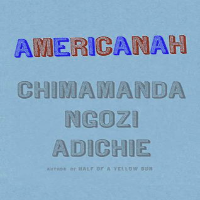

Sadness


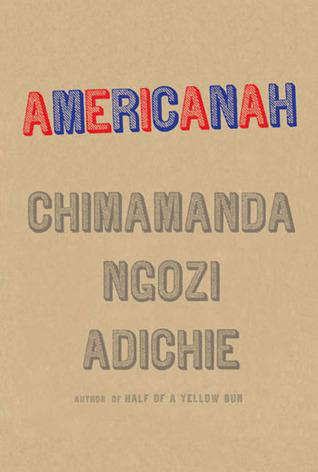

Sadness


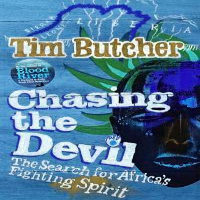

Sadness


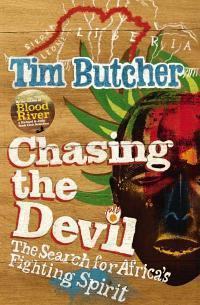

Sadness


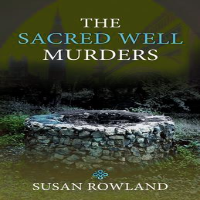

Sadness


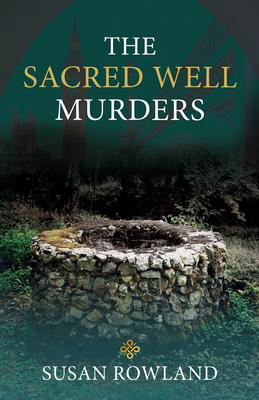

Sadness


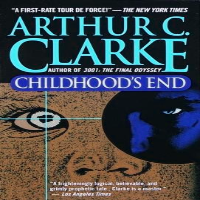

Sadness


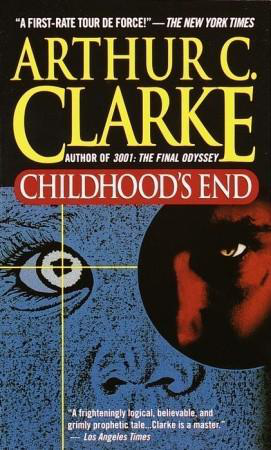

Fear


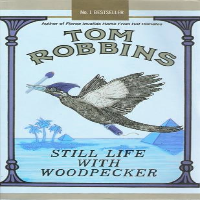

Sadness


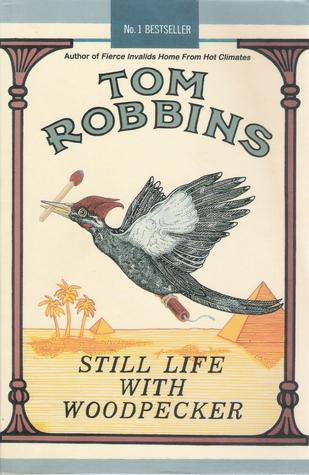

Fear


In [87]:
emotions = ["Happiness", "Sadness", "Fear", "Disgust", "Anger", "Surprise"]

for i in range(len(results)):
    display(Image.fromarray(X_test[rands[i]]))
    print(emotions[np.argmax(results[i])])
    display(Image.open(directory + str(actuals[i]) + ".jpg"))
    print(emotions[classes[actuals[i]]])

#### Testing out model (Oversampling)

In [11]:
ros = RandomOverSampler()

X_train_ros, y_train_ros = ros.fit_resample(
    X_train.reshape((-1, X_train.shape[1] * X_train.shape[2] * X_train.shape[3])),
    y_train
)

X_train_ros = X_train_ros.reshape((-1, X_train.shape[1], X_train.shape[2], X_train.shape[3]))
X_train_ros.shape, y_train_ros.shape

((8405, 200, 200, 3), (8405,))

In [12]:
# Necessary for ResNet Dense Layer
y_train_ros = np.eye(num_classes)[y_train_ros.reshape(-1)]
y_test = np.eye(num_classes)[y_test.reshape(-1)]

In [13]:
from tensorflow.keras.applications.resnet50 import ResNet50
base_model = ResNet50(weights= None, include_top=False, input_shape=(dimensions[0], dimensions[1], 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

from keras.optimizers import SGD, Adam
# sgd = SGD(learning_rate=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
model.fit(X_train_ros, y_train_ros, epochs=100, batch_size=64)

Epoch 1/100
130/130 [==============================] - 1258s 10s/step - loss: 1.8557 - accuracy: 0.4177
Epoch 2/100
130/130 [==============================] - 1290s 10s/step - loss: 0.9924 - accuracy: 0.6001
Epoch 3/100
130/130 [==============================] - 1270s 10s/step - loss: 0.7423 - accuracy: 0.6948
Epoch 4/100
130/130 [==============================] - 1248s 10s/step - loss: 0.5806 - accuracy: 0.7423
Epoch 5/100
130/130 [==============================] - 1315s 10s/step - loss: 0.4463 - accuracy: 0.7904
Epoch 6/100
130/130 [==============================] - 1270s 10s/step - loss: 0.3342 - accuracy: 0.8459
Epoch 7/100
130/130 [==============================] - 1271s 10s/step - loss: 0.2969 - accuracy: 0.8732
Epoch 8/100
130/130 [==============================] - 1211s 9s/step - loss: 0.2299 - accuracy: 0.8993
Epoch 9/100
130/130 [==============================] - 1452s 11s/step - loss: 0.2027 - accuracy: 0.9239
Epoch 10/100
130/130 [==============================] - 1231s 9s/

In [14]:
model.fit(X_train_ros, y_train_ros, epochs=25, batch_size=64)

Epoch 1/25
132/132 [==============================] - 1180s 9s/step - loss: 2.0631 - accuracy: 0.3792
Epoch 2/25
132/132 [==============================] - 1125s 9s/step - loss: 1.0150 - accuracy: 0.6178
Epoch 3/25
132/132 [==============================] - 1115s 8s/step - loss: 0.7566 - accuracy: 0.6878
Epoch 4/25
132/132 [==============================] - 1116s 8s/step - loss: 0.5423 - accuracy: 0.7667
Epoch 5/25
132/132 [==============================] - 1146s 9s/step - loss: 0.4451 - accuracy: 0.8000
Epoch 6/25
132/132 [==============================] - 1203s 9s/step - loss: 0.3526 - accuracy: 0.8447
Epoch 7/25
132/132 [==============================] - 1156s 9s/step - loss: 0.2993 - accuracy: 0.8807
Epoch 8/25
132/132 [==============================] - 1153s 9s/step - loss: 0.2514 - accuracy: 0.8953
Epoch 9/25
132/132 [==============================] - 1194s 9s/step - loss: 0.1634 - accuracy: 0.9361
Epoch 10/25
132/132 [==============================] - 1108s 8s/step - loss: 0.173

In [15]:
preds = model.evaluate(X_test, y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

26/26 [==============================] - 31s 1s/step - loss: 2.2845 - accuracy: 0.5735
Loss = 2.284522533416748
Test Accuracy = 0.57351154088974


In [16]:
model.save('./ModelSaves/ResNet50v3')

INFO:tensorflow:Assets written to: ./ModelSaves/ResNet50v3/assets


INFO:tensorflow:Assets written to: ./ModelSaves/ResNet50v3/assets


In [17]:
model.save('./ModelSaves/ResNet50v3_h5', save_format='h5')

...training
done training
[234, 977, 2286, 2721, 1459]
/book/show/13623848-the-song-of-achilles


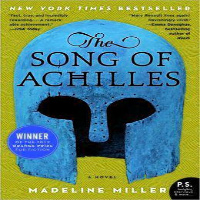

Sadness


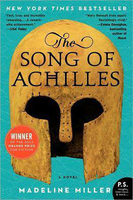

Sadness
/book/show/41057294-normal-people


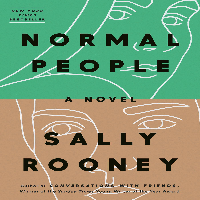

Sadness


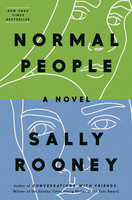

Happiness
/book/show/25489625-between-the-world-and-me


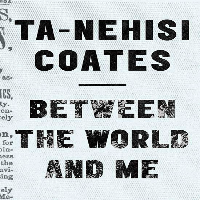

Sadness


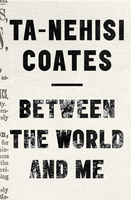

Fear
/book/show/33643994-daughter-of-the-pirate-king


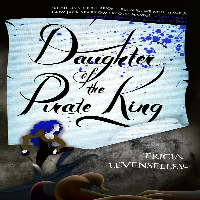

Sadness


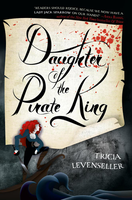

Disgust
/book/show/15724396-the-sword-of-summer


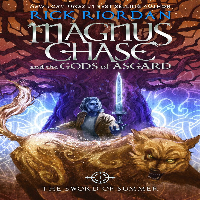

Sadness


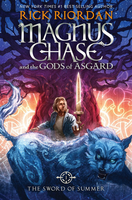

Anger


In [18]:
emotions = ["Happiness", "Sadness", "Fear", "Disgust", "Anger", "Surprise"]

emotion_presence = set()

rands = []

while len(rands) < 5:
    pos = random.randint(0, len(test_indices) - 1)
    if emotions[classes[test_indices[pos]]] not in emotion_presence:
        rands.append(pos)
        emotion_presence.add(emotions[classes[test_indices[pos]]])

print("...training")
        
results = model(X_test[rands])

print("done training")

actuals = [test_indices[pos] for pos in rands]
print(actuals)

for i in range(len(results)):
    print('========================================================')
    print(book_links[actuals[i]])
    display(Image.fromarray(X_test[rands[i]]))
    print(emotions[np.argmax(results[i])])
    im = Image.open(directory + str(actuals[i]) + ".jpg")
    im.thumbnail(dimensions, Image.ANTIALIAS)
    display(im)
    print(emotions[classes[actuals[i]]])
    print('========================================================')